# Statistical modeling using numpyro

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import numpyro
import numpyro.distributions as dist
import arviz as az

from numpyro.examples.datasets import LYNXHARE, load_dataset
from jax.experimental.ode import odeint


### Load dataset

Lotka-Volterra model is represented by the differential equations
$$
\frac{du}{dt} = \alpha u - \beta uv \\
\frac{dv}{dt} = \delta uv - \gamma v \\
$$

where 
* $u$ is population size of prey;
* $v$ is population size of predator;
* $t$ is time;
* $\alpha, \beta, \gamma, \delta$ are positive real parameters describing the interaction of the two species.


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<AxesSubplot: >

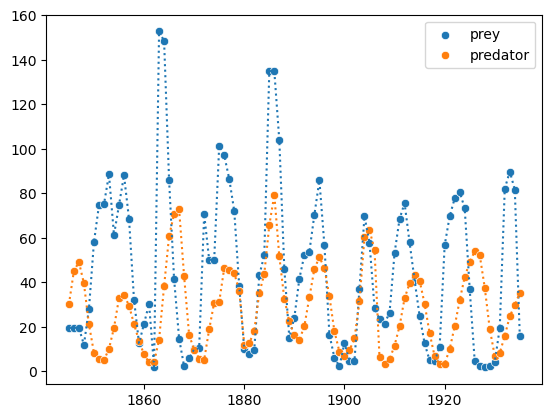

In [2]:
_, fetch = load_dataset(LYNXHARE, shuffle=False)
t, n = fetch()

sns.scatterplot(x = t, y = n[:, 0], label = 'prey')
sns.lineplot(x = t, y = n[:, 0], linestyle = 'dotted')
sns.scatterplot(x = t, y = n[:, 1], label = 'predator')
sns.lineplot(x = t, y = n[:, 1], linestyle = 'dotted')


### Define statistical model

Reference: https://num.pyro.ai/en/stable/examples/ode.html

In [3]:
def dz_dt(z, t, theta):
    """
    Lotka–Volterra equations. Real positive parameters `alpha`, `beta`, `gamma`, `delta`
    describes the interaction of two species.
    """
    u = z[0]
    v = z[1]
    alpha, beta, gamma, delta = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
    )
    du_dt = (alpha - beta * v) * u
    dv_dt = (-gamma + delta * u) * v
    return jax.numpy.stack([du_dt, dv_dt])


def model(N, y = None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jax.numpy.log(10), 1).expand([2]))
    # measurement times
    ts = jax.numpy.arange(float(N))
    # parameters alpha, beta, gamma, delta of dz_dt
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jax.numpy.array([1.0, 0.05, 1.0, 0.05]),
            scale=jax.numpy.array([0.5, 0.05, 0.5, 0.05]),
        ),
    )
    # integrate dz/dt, the result will have shape N x 2
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    # measurement errors
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    # measured populations
    numpyro.sample("y", dist.LogNormal(jax.numpy.log(z), sigma), obs = y)


In [4]:
iter_warmup = 1000
iter_sample = 1000
n_chain = 4

t_scaled = t.astype(float) - min(t.astype(float))

numpyro.set_host_device_count(n_chain)
nuts_kernel = numpyro.infer.NUTS(model, dense_mass=True)

mcmc = numpyro.infer.MCMC(nuts_kernel, num_warmup = iter_warmup, num_samples = iter_sample,
                          num_chains = n_chain, chain_method = 'parallel')


/tmp/ipykernel_14703/615974504.py:10: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts_kernel, num_warmup = iter_warmup, num_samples = iter_sample,


### Warmup

In [5]:
mcmc.warmup(jax.random.PRNGKey(0), y = n, N = n.shape[0], collect_warmup = True)

warmup: 100%|██████████| 1000/1000 [07:44<00:00,  2.15it/s, 1023 steps of size 7.36e-08. acc. prob=0.78]


/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>],
       [<AxesSubplot: title={'center': 'z_init'}>,
        <AxesSubplot: title={'center': 'z_init'}>]], dtype=object)

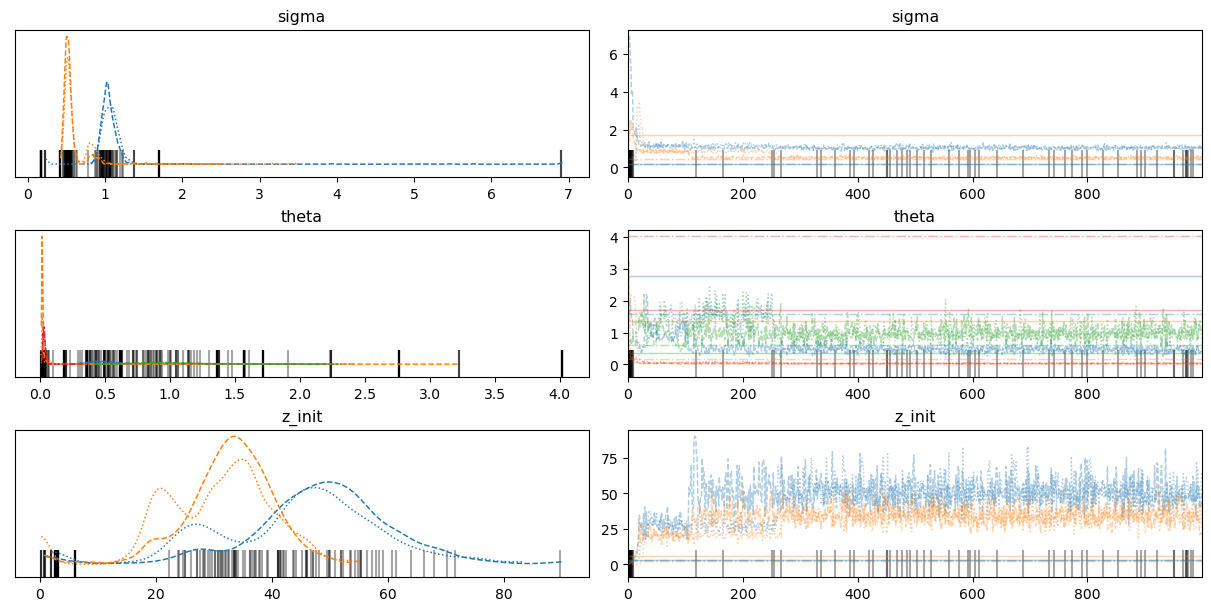

In [6]:
az.plot_trace(mcmc, backend_kwargs = {'constrained_layout': True})

### Run MCMC

In [7]:
mcmc.run(jax.random.PRNGKey(0), y = n, N = n.shape[0])

sample: 100%|██████████| 1000/1000 [07:42<00:00,  2.16it/s, 1023 steps of size 7.36e-08. acc. prob=0.80]


### Plot posteriors

/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>],
       [<AxesSubplot: title={'center': 'z_init'}>,
        <AxesSubplot: title={'center': 'z_init'}>]], dtype=object)

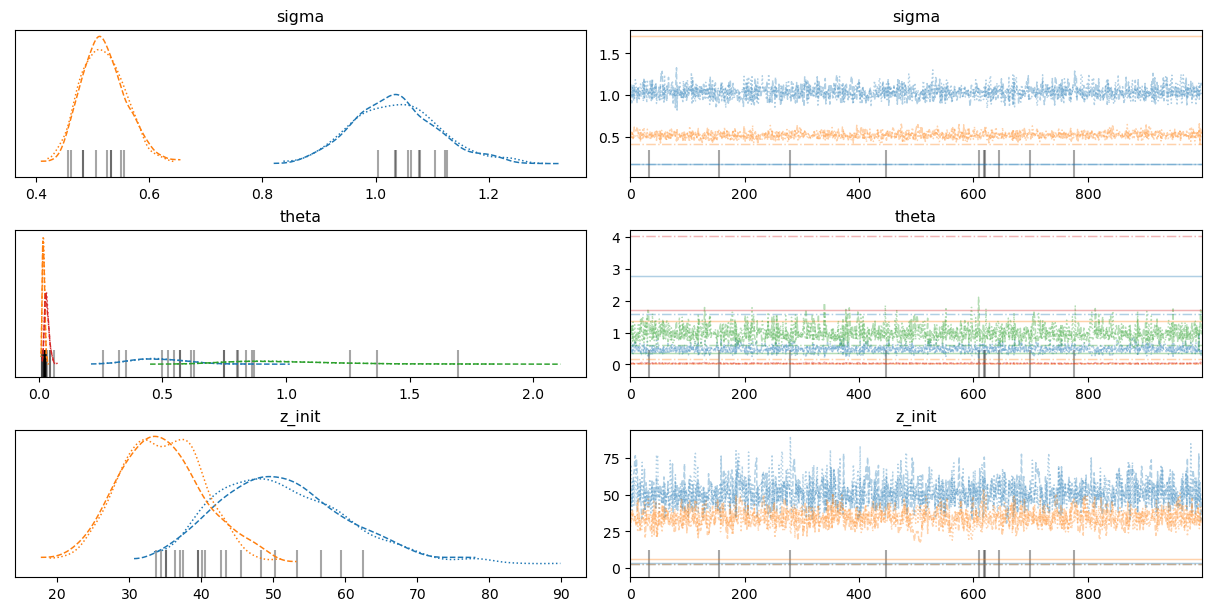

In [8]:
az.plot_trace(mcmc, backend_kwargs = {'constrained_layout': True})

### Get summary statistics

In [9]:
dict_diagnostics = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain = True), prob = 0.95, group_by_chain = True)
df_diagnostics = pd.DataFrame.from_dict(dict_diagnostics)

df_diagnostics

,sigma,theta,z_init
mean,"[0.60524386, 0.79069823]","[1.327381, 0.3960563, 0.7386903, 1.4514555]","[27.22151, 19.367617]"
std,"[0.43522182, 0.5297691]","[0.9438245, 0.5607472, 0.30987415, 1.6358764]","[25.005602, 15.631097]"
median,"[0.49802935, 0.5172738]","[1.2935398, 0.11276944, 0.6168991, 0.8967857]","[16.877304, 11.900955]"
2.5%,"[0.17052738, 0.418246]","[0.35149464, 0.0138203865, 0.36218774, 0.02257...","[2.9543316, 2.569267]"
97.5%,"[1.1365579, 1.7040627]","[2.7646337, 1.3600655, 1.2897938, 4.022077]","[63.587364, 42.172108]"
n_eff,"[2.0263282153254982, 2.005493555186148]","[2.0119419734990753, 2.0010589454383823, 2.606...","[2.115295944172228, 2.1238637160396157]"
r_hat,"[8.516075, 20.243979]","[13.045601, 177.5991, 2.02784, 264.4189]","[4.155128, 4.016848]"
